In [1]:
import matplotlib.pyplot as plt

column_names = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']

def plot_loss(history):
    h = history.history
    x_lim = len(h['loss'])
    plt.figure(figsize=(8, 8))
    plt.plot(range(x_lim), h['val_loss'], label = 'Validation Loss')
    plt.plot(range(x_lim), h['loss'], label = 'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

def plot_predictions(preds, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds, y_test, 'ro')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.plot([-0.5, 0.5], [-0.5, 0.5], 'b--')
    plt.show()
    return

def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds1, y_test, 'ro', label='Untrained Model')
    plt.plot(preds2, y_test, 'go', label='Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

In [5]:
!pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 23 kB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 3.8 MB 40.4 MB/s 
     |████████████████████████████████| 503 kB 55.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=cbf21475ab42802b20e766933282d4eecee2c3685667e50167595e07041dab59
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


In [7]:
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi

Mounted at /content/GDrive/
Connection to Google drive successful


In [10]:
df = pd.read_csv('/content/GDrive/My Drive/houseprice/data-2.csv', names = column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


check missing data

In [12]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

Data Normalization

iloc : selecting data for rows and columns

In [14]:
df = df.iloc[: , 1:]
df_norm = (df - df.mean())/ df.std()
df_norm.head()

,age,distance,stores,latitude,longitude,price
0,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


In [17]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
  return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


Creating Training and Test Set

In [20]:
x = df_norm.iloc[:, :6]
x.head()

,age,distance,stores,latitude,longitude,price
0,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


In [19]:
y = df_norm.iloc[:, -1]
y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

In [22]:
x_arr = x.values
y_arr = y.values

print('features shape', x_arr.shape)
print('labels shape', y_arr.shape)

features shape (5000, 6)
labels shape (5000,)


Train and Test split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size = 0.05, random_state = 0)

Creating the model


In [29]:
def get_model():
  model = Sequential([
       Dense(10, input_shape = (6,), activation = 'relu'),
       Dense(20, activation = 'relu'),
       Dense(5, activation = 'relu'),
       Dense(1)               
  ])
  model.compile(loss = 'mse', optimizer = 'adam')
  return model


In [30]:
from gc import callbacks
es_cb = EarlyStopping(monitor = 'val_loss', patience=5)

model = get_model()
preds_on_untrained = model.predict(x_test)
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, callbacks = [es_cb])

Epoch 1/10
149/149 [==============================] - 1s 3ms/step - loss: 0.2970 - val_loss: 0.1094
Epoch 2/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0596
Epoch 3/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0342
Epoch 4/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0195
Epoch 5/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0130
Epoch 6/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0089
Epoch 7/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 8/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 9/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 10/10
149/149 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0032

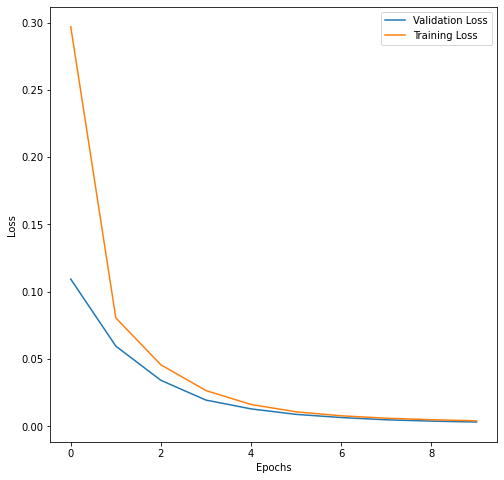

In [31]:
plot_loss(history)

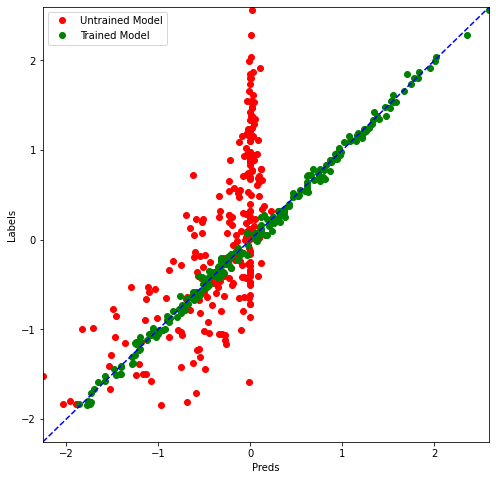

In [32]:
preds_on_trained = model.predict(x_test)
compare_predictions(preds_on_untrained, preds_on_trained, y_test)


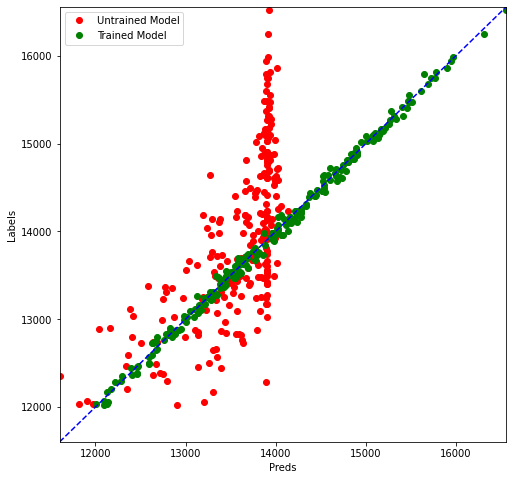

In [35]:
price_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_trained = [convert_label_value(y) for y in preds_on_trained]
price_test =[convert_label_value(y) for y in y_test]

compare_predictions(price_untrained, price_trained, price_test)